In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import quandl
from fredapi import Fred
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import yfinance as yf
from pandas_datareader.data import DataReader
pd.set_option("display.max_rows",200)



In [2]:


pd.set_option("display.max_rows",200)
sns.set(rc={'figure.figsize':(16,10)})
fred_key = "df4910b2cad947d95cf6ab16ba11d74d"
fred = Fred(api_key = fred_key)
quandl.ApiConfig.api_key = 'Qq5R29Xiqp2yUbb9dzNq'

In [3]:
def plot(prediction,target,grey=None,start=None,end=None):
    # if start is None:
    #     start=df.index.min()
    # if end is None:
    #     end=df.index.max()
    # recessions=DataReader('USREC', 'fred', start=start,end=end)['USREC']

    # pd.concat([,target],axis=1,ignore_index=False).plot()
    fig, ax = plt.subplots(figsize=(10, 3), dpi=300)
    
    # if isinstance(df,pd.DataFrame):
    # else:
    #     ylim = (df.min(),df.max())
        

    Results=pd.DataFrame(prediction,index=target.index)
    Results.plot(ax=ax,legend=True)
    Results['target']=target
    ylim = (Results.min().min(),Results.max().max())
    ax.fill_between(Results['target'].index, 0, ylim[1]+1e-2, Results['target'],facecolor='k', alpha=0.1)
    ax.legend(["Prediction", "NBER recession indicator"])
    return fig,ax

# DATA

## Fetching data from APIs

In [4]:
MacroCode=pd.read_csv(r'Data\Macro Variables.csv')
MacroCode.replace({'Average HOUST':'HOUST','S&P 500':'SP500'},inplace=True)

In [5]:
errors=[]
indicators={}
freq={}
for code in MacroCode['Variable']:
    if not ('S&P' in code):
        try:
            col=fred.get_series(code).to_frame(code).squeeze()
            if code == 'CPFFM':
                indicators[code]=(col)   #.resample('MS').last()
            elif code == "ICNSA":
                indicators[code]=(col).resample('MS').sum()
            elif code == "SP500":
                indicators[code]=(col).resample('MS').first()
            else:
                indicators[code]=(col) # .resample('M').interpolate()
        except ValueError:
            errors.append(code)

indicators['S&P: indust']=(yf.download('^SP500-20')['Close'].to_frame('S&P: indust').squeeze()).resample("MS").last()
indicators['S&P div yield']=(quandl.get("MULTPL/SP500_DIV_YIELD_MONTH").squeeze().to_frame('S&P div yield').squeeze()).resample("MS").last()
indicators['S&P PE ratio']=(quandl.get("MULTPL/SP500_PE_RATIO_MONTH").squeeze().to_frame('S&P PE ratio').squeeze())

[*********************100%***********************]  1 of 1 completed


In [6]:
if len(errors)>0:
    raise Exception("Erorrs found")
data=pd.concat(indicators,axis=1).copy()
# data.to_csv('Data/HistoricalVariables.csv')
print(data.shape)
data.isna().sum().sort_values()/data.shape[0]

(1860, 124)


S&P PE ratio       0.000000
S&P div yield      0.016667
AAA                0.326882
IPMANSICS          0.326882
INDPRO             0.326882
BAA                0.326882
AMBSL              0.342473
TB3MS              0.423656
NDMANEMP           0.455914
SRVPRD             0.455914
USGOOD             0.455914
USWTRADE           0.455914
USTRADE            0.455914
USFIRE             0.455914
USCONS             0.455914
PAYEMS             0.455914
USTPU              0.455914
DMANEMP            0.455914
USGOVT             0.455914
CES3000000008      0.455914
IPFPNSS            0.455914
IPFINAL            0.455914
MANEMP             0.455914
AWHMAN             0.455914
IPCONGD            0.455914
IPMAT              0.455914
TOTALSL            0.482258
NONREVSL           0.482258
DTCOLNVHFNM        0.482796
DTCTHFNM           0.482796
WTISPLC            0.501075
CPIMEDSL           0.507527
CPITRNSL           0.507527
CES0600000007      0.507527
CPIULFSL           0.507527
REALLN             0

In [7]:
def deltaX(data):
    return data.diff()

def delta2X(data):
    return data-2*data.shift(1)+data.shift(2)

def logdata(data):
    return np.log(data)

def difflog(data):
    return np.log(data).diff()

def difflog2(data):
    return np.log(data)-2*np.log(data.shift(1))+np.log(data.shift(2))

def diffpercent(data):
    return (data/data.shift() - 1) - (data.shift()/data.shift(2) - 1)



transformation={1:(lambda x: x),
                2:deltaX,
                3:delta2X,
                4:logdata,
                5:difflog,
                6:difflog2,
                7:diffpercent,
                }
df_transformed=pd.DataFrame()
for column in data.columns:
    type=MacroCode[MacroCode['Variable'] == column]['Transformation'].iloc[0]
    df_transformed[column]=transformation[type](data[column])
    df_transformed=df_transformed.copy()
df_transformed=df_transformed.fillna(method="ffill").dropna(thresh=110)

## Adding Recession

In [8]:
df=df_transformed.copy()
recessions =  DataReader('USREC', 'fred', start='1800')
df[f'in a recession']=recessions
df['target'] = recessions.shift(-9)
df.shape

(659, 126)

(<Figure size 3000x900 with 1 Axes>, <Axes: >)

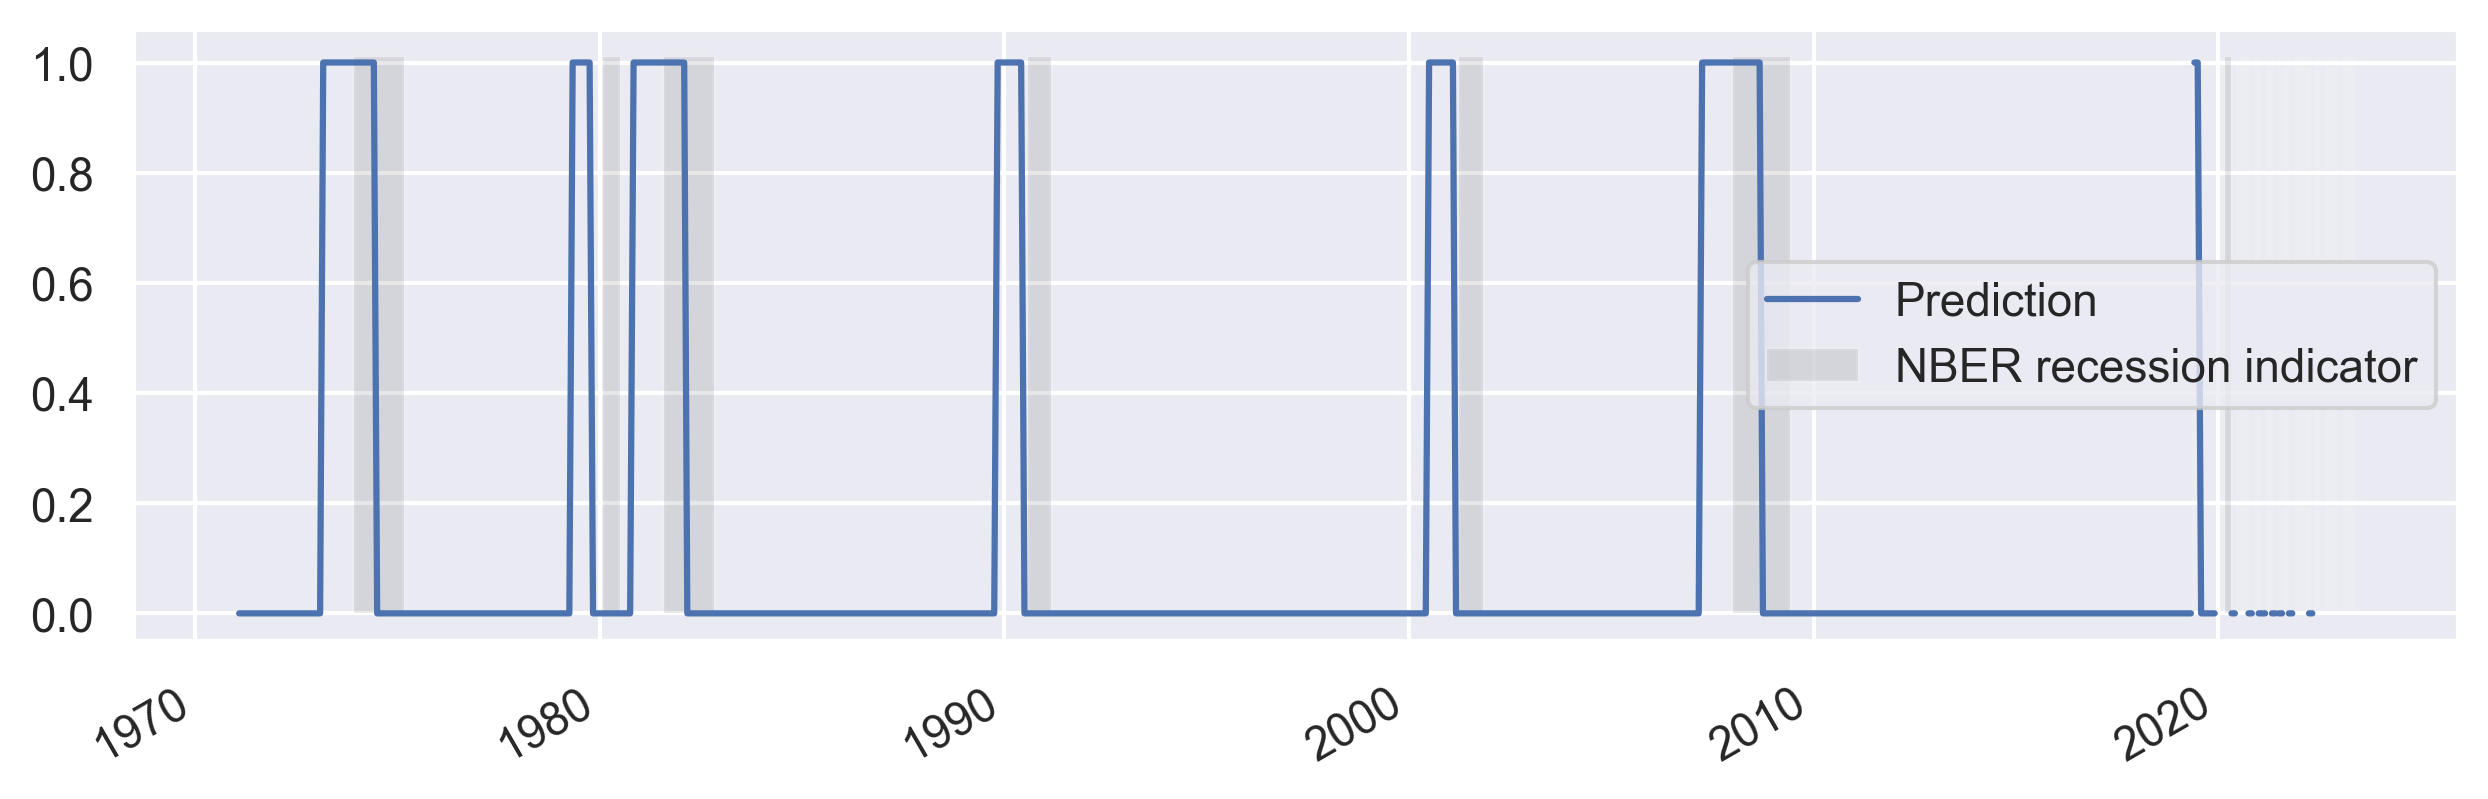

In [9]:
plot(df.iloc[:,-1],df.iloc[:,-2])

# Data Processing

In [10]:
def createXY(dataset,n_lookback = 60,n_forecast = 3,target_col=-1):
    X = []
    Y = []

    for i in range(n_lookback, len(dataset) - n_forecast + 1):
        X.append(dataset[i - n_lookback: i, 0:dataset.shape[1]-1])
        Y.append(dataset[i: i + n_forecast,target_col])

    return np.array(X),np.array(Y)

In [11]:
df.shape

(659, 126)

In [59]:
n_lookback=12
n_forecast=1

df_for_training=df[:"2003-01-01"]
df_for_validating=df["1996-01-01":"2003-01-01"]
df_for_testing=df["2003":"2022"]


<Axes: >

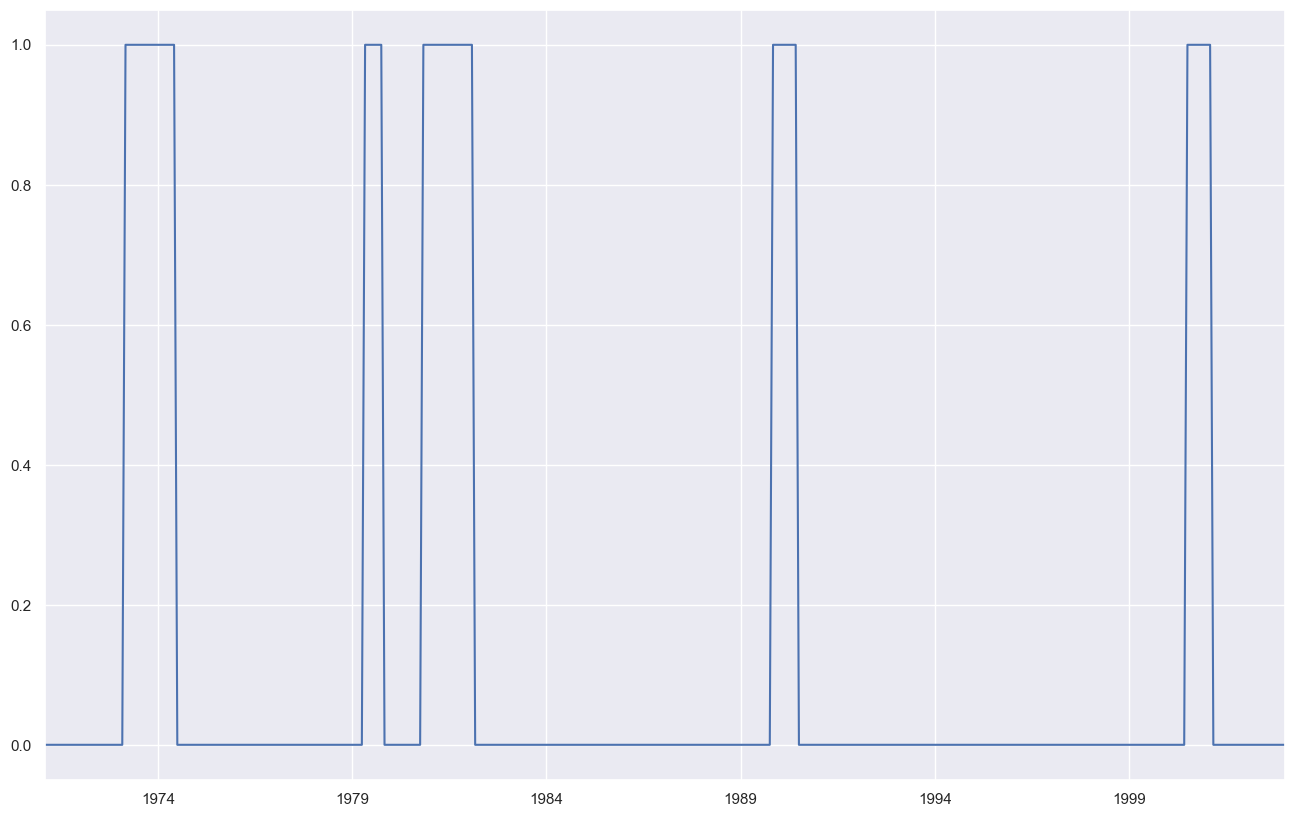

In [60]:
df_for_training.iloc[:,-1].plot()

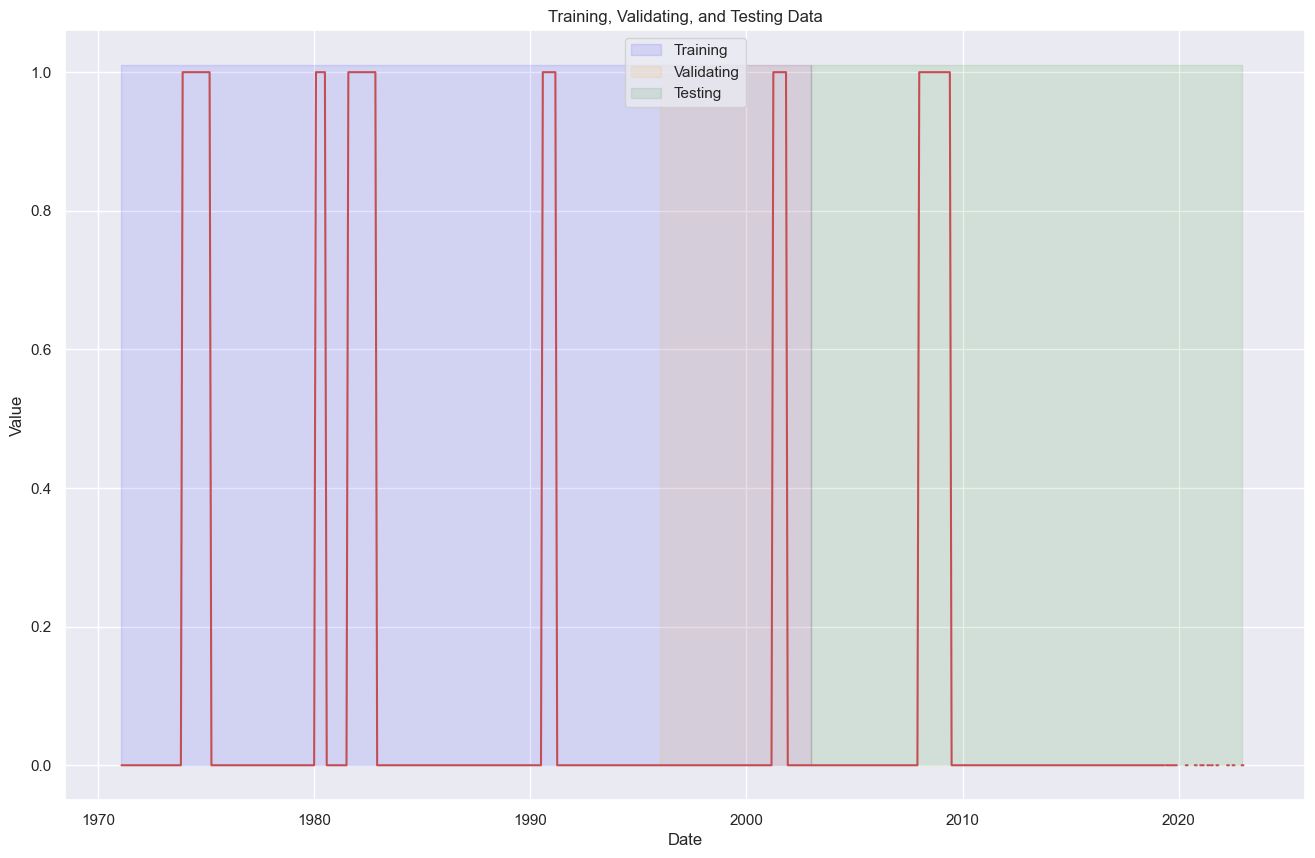

In [61]:
# Extract the last column from each dataframe
train_data = df_for_training.iloc[:, -2].copy()
valid_data = df_for_validating.iloc[:, -2].copy()
test_data = df_for_testing.iloc[:, -2].copy()

train_data.loc[:] =1
valid_data.loc[:] =1
test_data.loc[:]  =1

# Create a figure and axis
# Create a figure and axis
fig, ax = plt.subplots()

# Shade the training period
ax.fill_between(train_data.index, 0,1+1e-2, color='blue', alpha=0.1)
# Shade the validating period
ax.fill_between(valid_data.index,  0,1+1e-2, color='orange', alpha=0.1)
# Shade the testing period
ax.fill_between(test_data.index,  0,1+1e-2, color='green', alpha=0.1)

ax.plot(df.index, df.iloc[:,-2],color='r')


# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Training, Validating, and Testing Data')

# Add legend
ax.legend(['Training','Validating','Testing'])

# Display the graph
plt.show()

In [62]:

print('df_for_training shape: ',df_for_training.shape)
print('df_for_validating shape: ',df_for_validating.shape)
print('df_for_testing shape: ',df_for_testing.shape)

# Scalling

scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training.fillna(0))
df_for_validating_scaled = scaler.transform(df_for_validating.fillna(0))
df_for_testing_scaled=scaler.transform(df_for_testing.fillna(0))

print()
trainX,trainY=createXY(df_for_training_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
validX,validY=createXY(df_for_validating_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
testX,testY=createXY(df_for_testing_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
trainX.shape,validX.shape,testX.shape

df_for_training shape:  (384, 126)
df_for_validating shape:  (85, 126)
df_for_testing shape:  (268, 126)



((372, 12, 125), (73, 12, 125), (256, 12, 125))

# Prediction 

## TCN

In [63]:
def CustomLoss(labels, pred,w=0.3): 
    logits=tf.math.log(pred/(1-pred))
    return tf.nn.weighted_cross_entropy_with_logits(labels, logits, w)

In [108]:
from tcn import TCN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [185]:
PT_path = 'Model/TCN-test'
f1 = EarlyStopping(monitor='recall', mode='max', verbose=1, patience=30)
f2 = ModelCheckpoint(filepath=PT_path, monitor='recall',
                     mode='max', verbose=0, save_best_only=True)


model = Sequential()
model.add(InputLayer(input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(TCN(nb_filters=100, kernel_size=3, dilations=[27,36], 
              padding='causal', return_sequences=False))
# model.add(LSTM(100, return_sequences=False))
model.add(Dense((n_forecast), activation='sigmoid'
                ))
model.summary()


# fit the model
model.compile(optimizer='adam',
              metrics=['Recall', 'Precision', "AUC"],
              loss=CustomLoss
              # loss='BinaryCrossentropy'
              )
# fit the model
history = model.fit(trainX, trainY, epochs=150, batch_size=500,
                    # validation_data=(validX,validY),
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[
                        #  f1,
                        # f2
                    ]
                    )

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_26 (TCN)                (None, 900)               7744500   
                                                                 
 dense_50 (Dense)            (None, 1)                 901       
                                                                 
Total params: 7,745,401
Trainable params: 7,745,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
1/1 [==============================] - 110s 110s/step - loss: 0.9464 - recall: 1.0000 - precision: 0.1549 - auc: 0.5172 - val_loss: 0.2658 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 2/150


KeyboardInterrupt: 

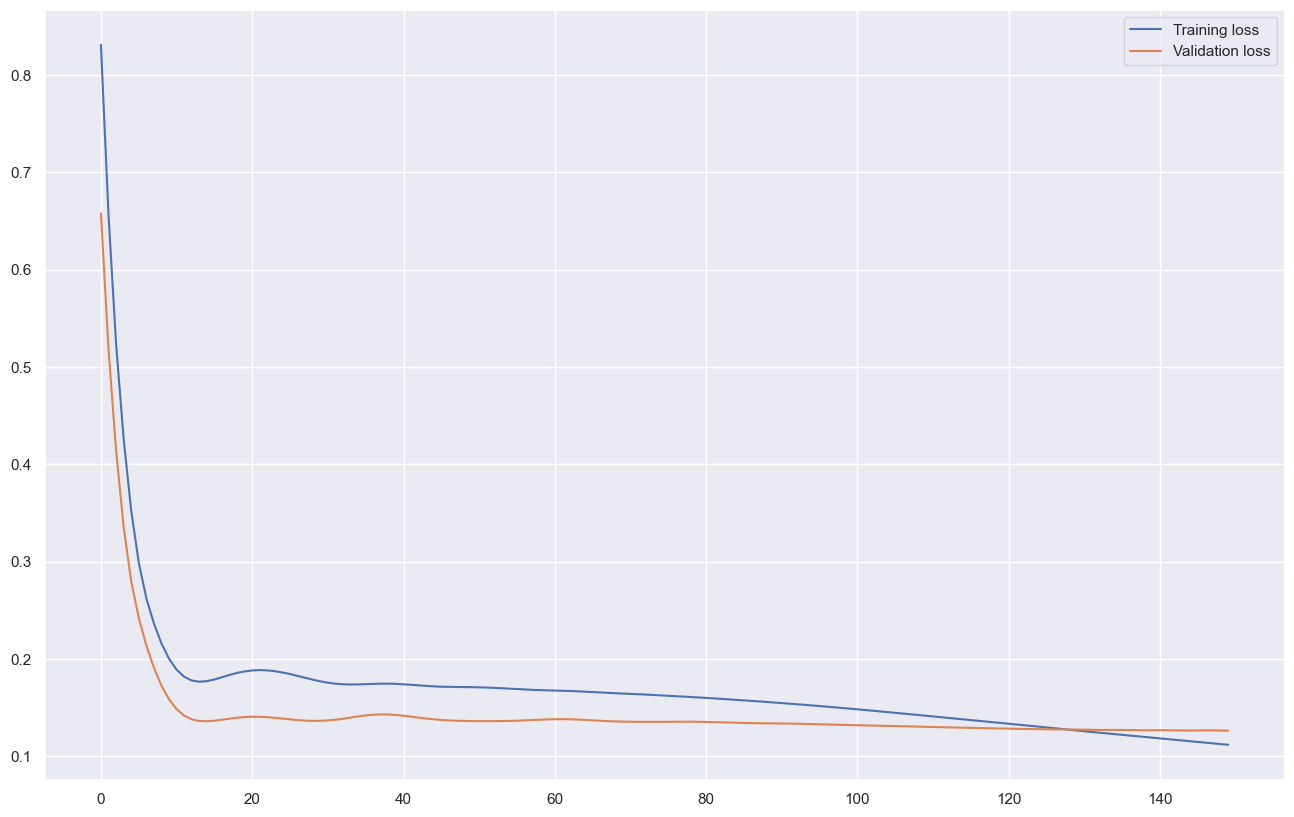

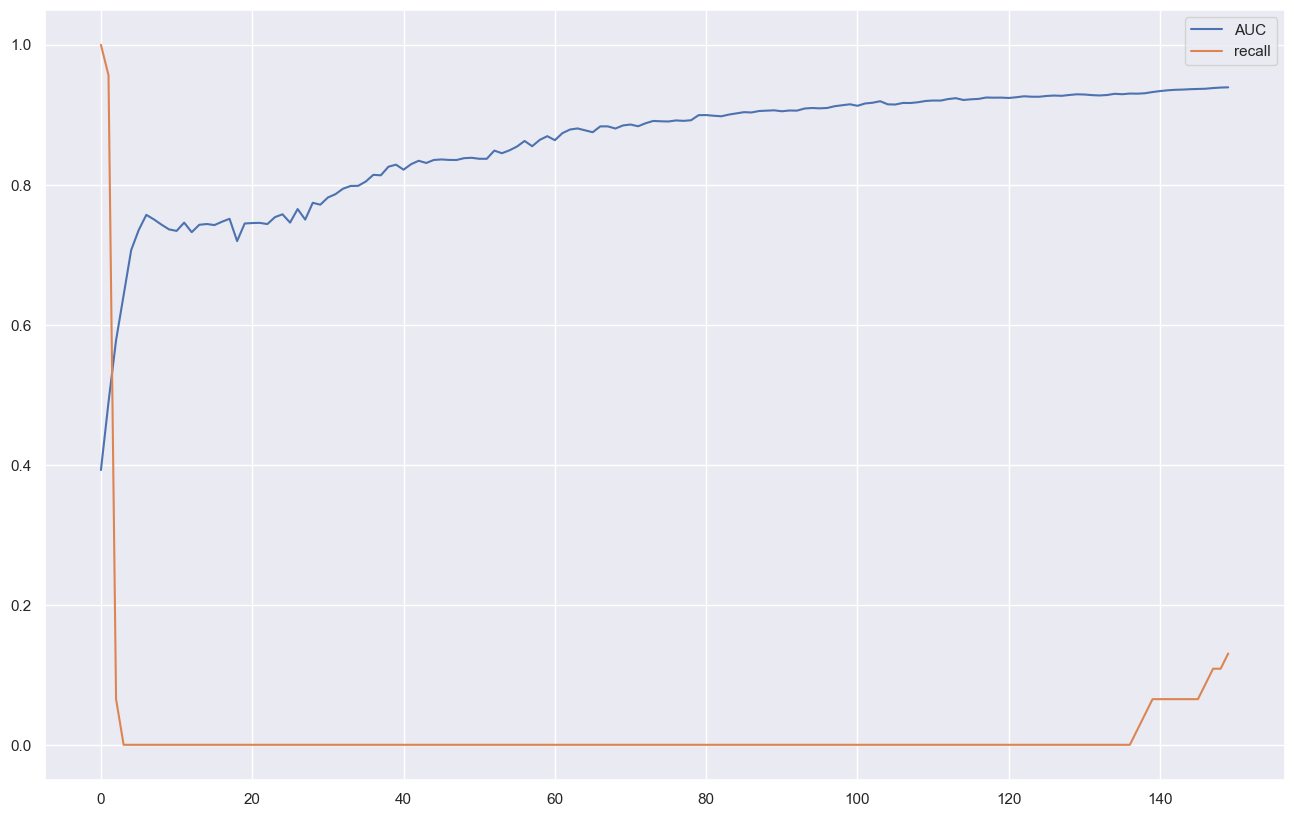

In [ ]:

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show();
plt.plot(history.history['auc'], label='AUC')
plt.plot(history.history['recall'], label='recall')
plt.legend()

In [ ]:
# best_model=tf.keras.models.clone_model(model)
# best_model.load_weights(PT_path)

In [ ]:
prediction_train=model.predict(trainX)
prediction_valid=model.predict(validX)
prediction=model.predict(testX)
trainResults= pd.DataFrame()
validResults = pd.DataFrame()
testResults = pd.DataFrame()
min_length_train = min(len(df_for_training), len(prediction_train))
trainResults['Actual']=df_for_training.iloc[-min_length_train:,-2]
trainResults['Pred']=prediction_train[-min_length_train:]
min_length_valid = min(len(df_for_validating), len(prediction_valid))
validResults['Actual']=df_for_validating.iloc[-min_length_valid:, -2]
validResults["Pred"]=prediction_valid[-min_length_valid:]
min_length_test = min(len(df_for_testing), len(prediction))
testResults['Actual']=df_for_testing.iloc[-min_length_test:,-2]
testResults['Pred']=prediction[-min_length_test:]


8/8 [==============================] - 0s 6ms/step


(<Figure size 3000x900 with 1 Axes>, <Axes: >)

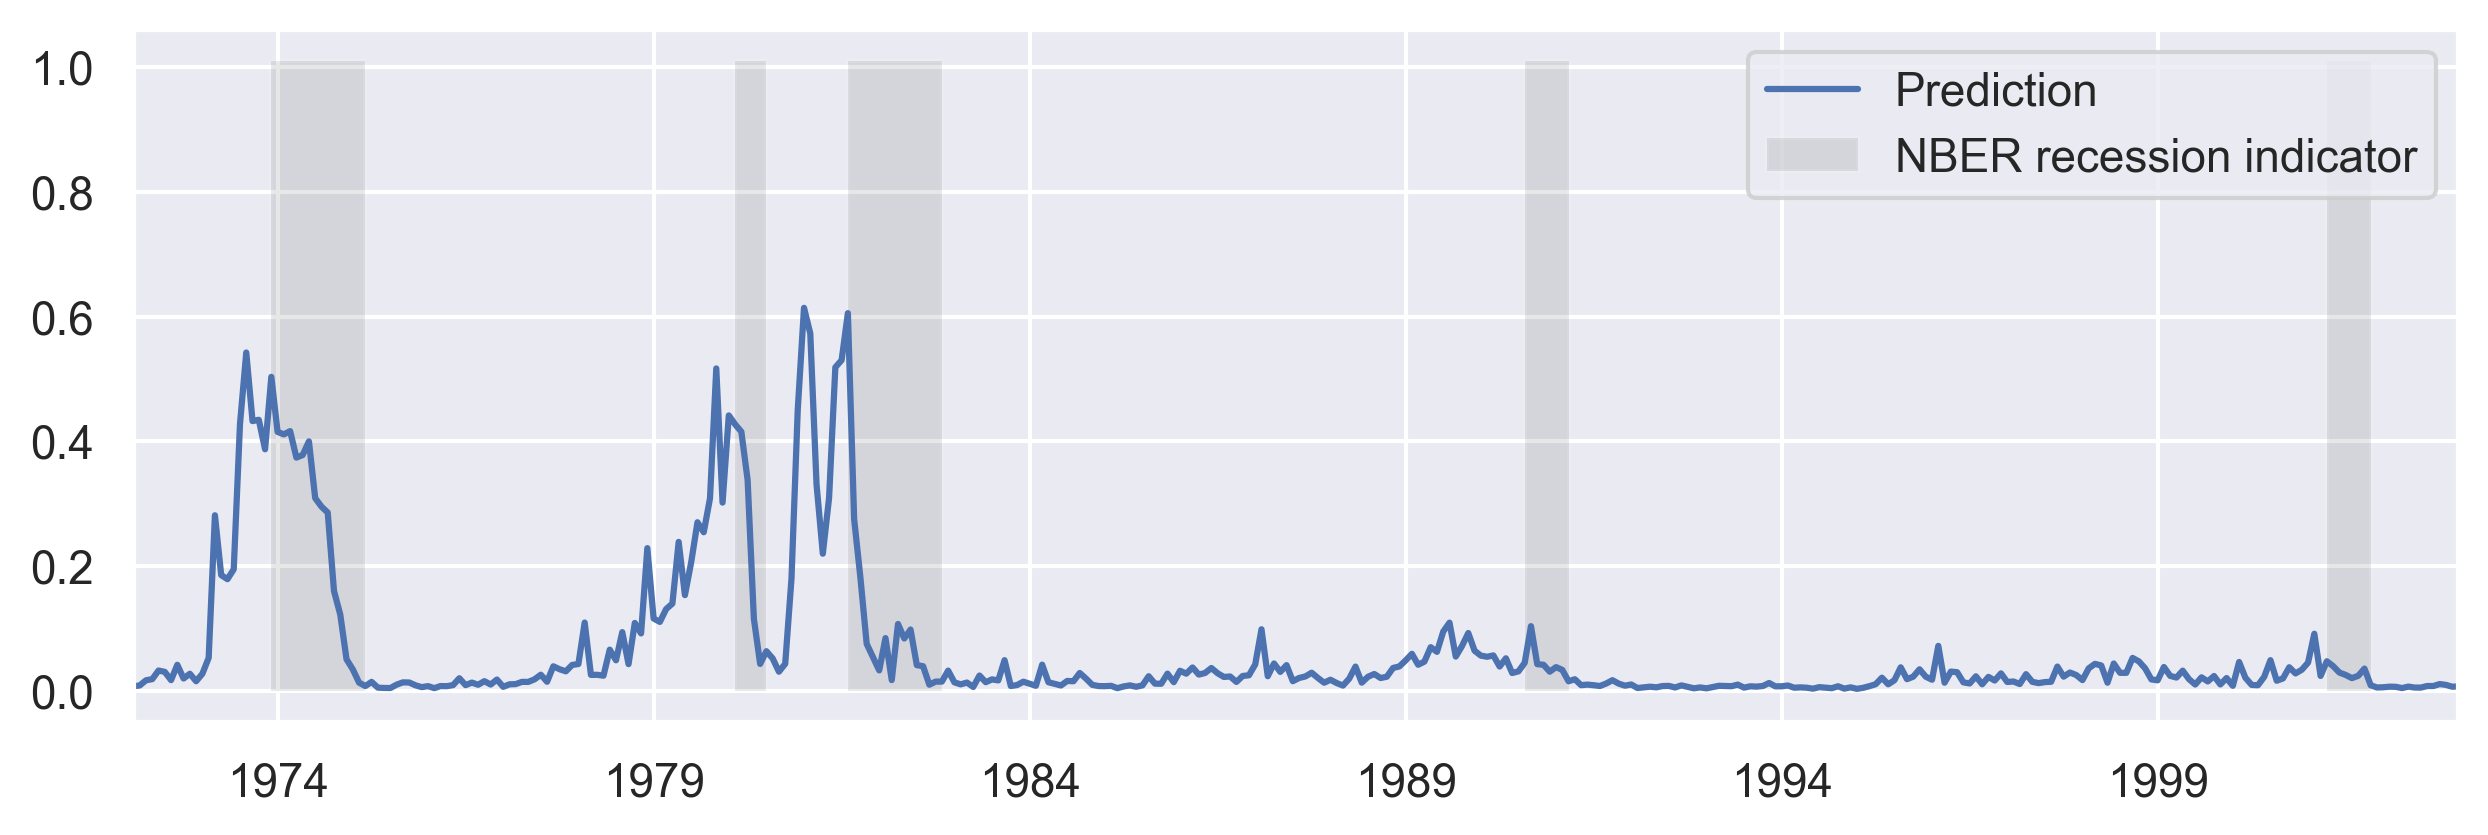

In [ ]:

plot((trainResults['Pred']),df_for_training.iloc[-min_length_train:,-2])


In [ ]:
# plot((validResults['Pred']),validResults["Actual"])


(<Figure size 3000x900 with 1 Axes>, <Axes: >)

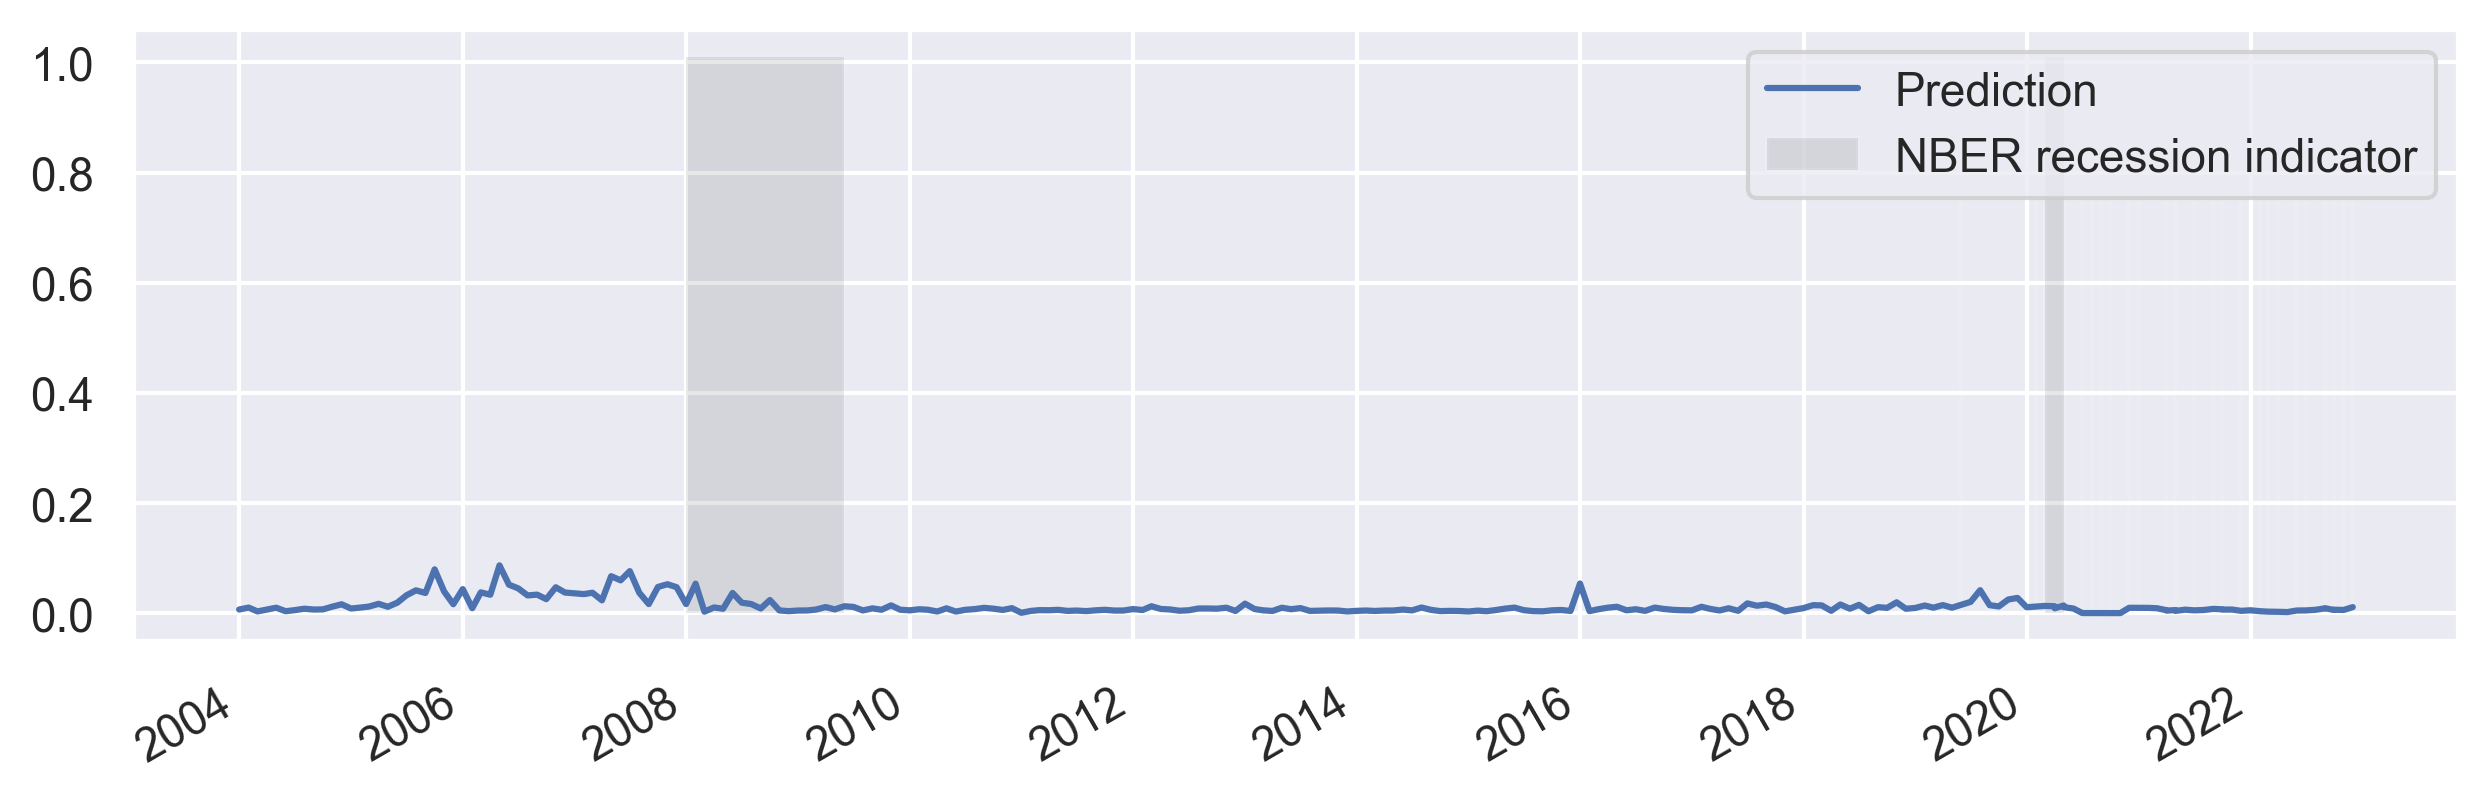

In [ ]:
plot((testResults['Pred']),df_for_testing.iloc[-min_length_test:,-2])